[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/matteo-bertini/Facial-Expression-Recognition)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matteo-bertini/Facial-Expression-Recognition/blob/main/ResNet152V2.ipynb)

# Importing the libraries
The libraries to implement Five-Layers-CNN and related utilities are imported here.

In [58]:
import random
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow import keras
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Conv2D
from keras.applications import VGG16 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D,ReLU,RandomRotation
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow import keras,convert_to_tensor
from sklearn.model_selection  import train_test_split
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Utilities
Here we declare some functions that will be useful later.

In [88]:
# Returns a batch with n samples from the set passed in input
def random_images(X,y,n):
  X_len = X.shape[0]
  ran_indices = random.sample(range(0,X_len,1),n)
  to_ret_X = []
  to_ret_y = []
  for i in range(0,n):
    to_ret_X.append(X[ran_indices[i]])
    to_ret_y.append(y[ran_indices[i]])

  return tf.stack(to_ret_X),tf.stack(to_ret_y)

# Plots the images and their labels passed in input 
def print_images_with_labels(X,y):
  emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
  num_images = X.shape[0]
  fig = plt.figure(figsize = (2*num_images,2*num_images))
  for i in range(0,num_images):
    fig.add_subplot(1,num_images,i+1)
    plt.axis("off")
    plt.imshow(X[i].numpy().reshape(48,48),cmap="gray")
    plt.title(emotions[y[i].numpy().argmax()])
  plt.show(fig)
  return

# GPU Check
This section checks whether the GPU is in use or not.

In [4]:
num_gpu_available = len(tf.config.list_physical_devices('GPU'))
if num_gpu_available == 0 :
  print("You are not using GPU.\n")
else:
  print("You are using GPU.\n")

You are not using GPU.



In [ ]:
# Command to run to see the specs of the assigned GPU. (only valid if GPU is in use)
!nvidia-smi

Fri Jan 20 16:09:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset
The dataset provided by the .csv file is uploaded and processed here.


## Loading the dataset from the csv file
In this section the file "icml_face_data.csv" is loaded inside a dataframe, which is processed and then divided into three other dataframes (one for train, one for validation and one for test) according to the value of the "usage" column.

In [4]:
# Loading icml_face_data.csv into dataframe df_icml
df_icml = pd.read_csv("/content/drive/MyDrive/Facial-Expression-Recognition/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv",sep=",")

# Columns renamed for easier access.
df_icml.rename(columns = {' Usage':'usage'}, inplace = True)
df_icml.rename(columns = {' pixels':'pixels'}, inplace = True)

# Transforming pixel strings into 48x48x1 numpy arrays of float32
df_icml["pixels"] = df_icml['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48,1).astype('float32'))
# Transforming 48x48x1 numpy arrays into 48x48x3 by coping the first channel
#df_icml["pixels"] = df_icml["pixels"].apply(lambda x : np.repeat(a=x,repeats=3,axis = 2))

# Creating the X numpyarray
X = df_icml["pixels"]
X = np.stack(X, axis=0)
X=X/255.0
print("X has shape: ")
print(X.shape)

# Creating the y numpyarray
y = df_icml["emotion"].to_numpy()
y = to_categorical(y)
print("y has shape: ")
print(y.shape)

print("\n")

# Data Augmentation phase 

# Declaration of the ImageDataGenerator with the transformations to apply to generate new images
data_gen = ImageDataGenerator(rotation_range = 15,width_shift_range = 0.15,height_shift_range = 0.15,shear_range = 0.15,zoom_range = 0.15,horizontal_flip = True)

# Disgust Class 

# Creating the X numpyarray with samples from disgust class
X_disg = df_icml.loc[df_icml['emotion'].isin([1])]["pixels"]
X_disg = np.stack(X_disg, axis=0)
X_disg = X_disg/255.0
print("X_disg has shape: ")
print(X_disg.shape)

# Creating the y numpyarray with samples from disgust class
y_disg = np.zeros((547,7))
for i in range (0,y_disg.shape[0]):
  y_disg[i][1] = 1 
print("y_disg has shape: ")
print(y_disg.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_disg)
  it = data_gen.flow(X_disg,y_disg,batch_size = 547,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1


# Surprise Class 

# Creating the X numpyarray with samples from surprise class
X_surp = df_icml.loc[df_icml['emotion'].isin([5])]["pixels"]
X_surp = np.stack(X_surp, axis=0)
X_surp = X_surp/255.0
print("X_surp has shape: ")
print(X_surp.shape)

# Creating the y numpyarray with samples from surprise class
y_surp = np.zeros((4002,7))
for i in range (0,y_surp.shape[0]):
  y_surp[i][5] = 1 
print("y_surp has shape: ")
print(y_surp.shape)
print("\n")

# Adding the newly created images and labels to the original dataset
i = 0
while i < 9:
  data_gen.fit(X_surp)
  it = data_gen.flow(X_surp,y_surp,batch_size = 200,shuffle = True)
  X_to_add = it.next()[0]
  y_to_add = it.next()[1]
  X = np.concatenate((X,X_to_add),axis = 0)
  y = np.concatenate((y,y_to_add),axis = 0)
  i=i+1

print(X.shape,y.shape)

# Creating the train,val,test split using sklearn library 
# ( the stratify option retains the same proportion of classes in the train and test
#  sets that are found in the entire original dataset,it helps in the building of balanced train-test splits)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state = 42)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,shuffle=True,stratify=y_test,random_state=42)

# Transforming sets from numpy array to tensors
X_train = convert_to_tensor(X_train)
X_val = convert_to_tensor(X_val)
X_test = convert_to_tensor(X_test)
print("Sets shapes:")
print("X_train has shape: ")
print(X_train.shape)
print("y_train has shape: ")
print(y_train.shape)
print("X_val has shape: ")
print(X_val.shape)
print("y_val has shape: ")
print(y_val.shape)
print("X_test has shape: ")
print(X_test.shape)
print("y_test has shape: ")
print(y_test.shape)


X has shape: 
(35887, 48, 48, 1)
y has shape: 
(35887, 7)


X_disg has shape: 
(547, 48, 48, 1)
y_disg has shape: 
(547, 7)


X_surp has shape: 
(4002, 48, 48, 1)
y_surp has shape: 
(4002, 7)


(42610, 48, 48, 1) (42610, 7)
Sets shapes:
X_train has shape: 
(34088, 48, 48, 1)
y_train has shape: 
(34088, 7)
X_val has shape: 
(4261, 48, 48, 1)
y_val has shape: 
(4261, 7)
X_test has shape: 
(4261, 48, 48, 1)
y_test has shape: 
(4261, 7)


## Assignment of class weights
In this section, class weights are calculated and assigned. These weights are useful in the training phase to manage the imbalance between classes that emerged in the Exploratory Data Analysis.
The following formula will be used to calculate the class weights:\
          **wj = n_samples / (n_classes * n_samplesj)**\
where:


*   wj is the weight for each class (j is the index of the class)
*   n_samples is the total number of samples or rows in the dataset
*   n_classes is the total number of unique classes in the dataset
*   n_samplesj is the total number of rows of the respective class (j is the index of the class)





In [5]:
# computing the total number of samples in the train set
n_samples = y_train.shape[0]

# declaration of the weights dictionary to pass in the training phase
weights = {0:0.0,1:0.0,2:0.0,3:0.0,4:0.0,5:0.0,6:0.0}

# counting n_samples j for each class
for j in range(n_samples):
  idx = y_train[j].argmax()
  weights[idx]=weights[idx]+1

print(weights)
# computing the weights for each class
for j in range(7):
  weights[j] = n_samples/ (7* weights[j])

# visualizing the weights
display(weights)

{0: 3962.0, 1: 4376.0, 2: 4097.0, 3: 7191.0, 4: 4862.0, 5: 4642.0, 6: 4958.0}


{0: 1.2291050695896732,
 1: 1.1128231914337947,
 2: 1.1886049025419296,
 3: 0.6771957009754256,
 4: 1.001586648645472,
 5: 1.049055210192651,
 6: 0.9821932807007434}

## Creating the network structure
Here the architecture of ResNet152V2 is imported from the library.


In [74]:
to_add = VGG16(include_top = False,weights="imagenet",input_shape=(48,48,3))
model = Sequential()
model.add(Conv2D(filters = 3,kernel_size = (3, 3),input_shape = (48, 48, 1),padding = 'same',kernel_initializer = 'he_normal',kernel_regularizer = L2(0.02),bias_regularizer = L2(0.02)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))
model.add(to_add)
model.add(Flatten(name='flatten'))     
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

# After creating the structure of the network, we visualize it in a compact way.
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 batch_normalization_26 (Bat  (None, 48, 48, 3)        12        
 chNormalization)                                                
                                                                 
 re_lu_26 (ReLU)             (None, 48, 48, 3)         0         
                                                                 
 dropout_22 (Dropout)        (None, 48, 48, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                     

## Compiling the model
In this section the model is compiled, in particular are defined:


*   the loss function (categorical crossentropy)
*   the optimizator (adam optimizer)
*   the evaluation metrics (accuracy)







In [75]:
# defining the loss function,the optimizer and the evaluation metrics
opt = keras.optimizers.Adam(learning_rate = 0.0001,amsgrad=True)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = ['accuracy']
)


In [77]:
# defining some callbacks 

# this callback reduces learning rate when the metric passed has stopped improving (prevents overfitting)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=2,min_lr=0,verbose=1)

# this callback stops training when a monitored metric has stopped improving (prevents overfitting)
early_stopping = EarlyStopping(monitor = "val_loss",min_delta = 0.0035,patience = 10,verbose = 1)

callbacks = [reduce_lr]

# Training the VGG16
in this section the net is trained on the training set.

In [78]:
# Training the net

print("Training:\n")
batch_size = 128
epochs = 12
history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val, y_val))

# Saving the history to visualize the learning curves even without having trained the network (future use)
print("\n")
in1 = int(input("Do you want to save this training history? (1 = yes,0= no)\n"))
if(in1 == 1):
  with open("/content/drive/MyDrive/Facial-Expression-Recognition/VGG16/VGG16_history.pi", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
else:
  pass


Training:

Epoch 1/12
267/267 [==============================] - 28s 101ms/step - loss: 1.9073 - accuracy: 0.3040 - val_loss: 2.0483 - val_accuracy: 0.3039
Epoch 2/12
267/267 [==============================] - 27s 101ms/step - loss: 1.5564 - accuracy: 0.4492 - val_loss: 3.1198 - val_accuracy: 0.1572
Epoch 3/12
267/267 [==============================] - 27s 102ms/step - loss: 1.3994 - accuracy: 0.5090 - val_loss: 2.3011 - val_accuracy: 0.3886
Epoch 4/12
267/267 [==============================] - 27s 103ms/step - loss: 1.2981 - accuracy: 0.5453 - val_loss: 2.5542 - val_accuracy: 0.4382
Epoch 5/12
267/267 [==============================] - 27s 103ms/step - loss: 1.2078 - accuracy: 0.5795 - val_loss: 1.9864 - val_accuracy: 0.4536
Epoch 6/12
267/267 [==============================] - 28s 104ms/step - loss: 1.1340 - accuracy: 0.6046 - val_loss: 1.5521 - val_accuracy: 0.5478
Epoch 7/12
267/267 [==============================] - 28s 104ms/step - loss: 1.0653 - accuracy: 0.6280 - val_loss: 1.42

# Learning curves visualization
Here the learning curves are displayed.
In particular, it is displayed how the loss and accuracy change for the training set and for the validation set during the various training epochs.

In [79]:
# Loading training history from saved file
with open("/content/drive/MyDrive/Facial-Expression-Recognition/VGG16/VGG16_history.pi", "rb") as file_pi:
    history = pickle.load(file_pi)

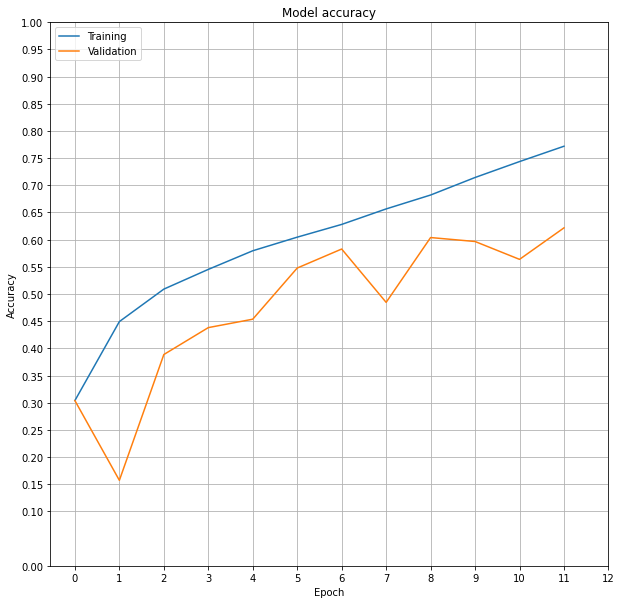

In [80]:
# visualizing the accuracy learning curve

# creating the figure
acc_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history["accuracy"])                                                         
plt.plot(history['val_accuracy'])  

# setting plot title
plt.title('Model accuracy')

# setting x and y ticks and labels for the plot
plt.ylabel('Accuracy')
plt.yticks([0.0,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0])
plt.xlabel('Epoch')
plt.xticks(range(0,epochs+1))

# setting the legend for the plot
plt.legend(['Training', 'Validation'], loc='upper left')

# adding the grid
plt.grid()

# showing the figure
plt.show(acc_lc)

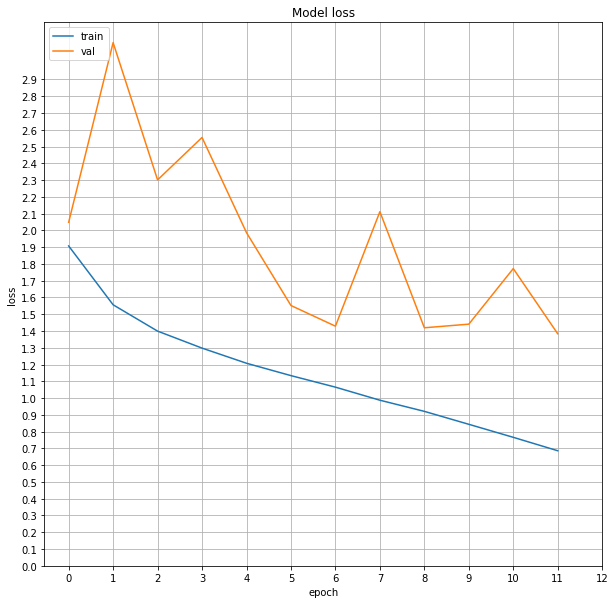

In [81]:
# visualizing the loss learning curves

# creating the figure
loss_lc = plt.figure(figsize = (10,10))

# plotting training and validation accuracy
plt.plot(history['loss'])                                                         
plt.plot(history['val_loss'])  

# setting plot title
plt.title('Model loss')

# setting x and y ticks and labels for the plot
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0,epochs+1))
plt.yticks(np.arange(0,3,0.1))

# setting the legend for the plot
plt.legend(['train', 'val'], loc='upper left')

# adding the grid
plt.grid()

# showing the figure
plt.show(loss_lc)

# Testing the VGG16

In [82]:
test_history = model.evaluate(X_test,y_test,batch_size = 8)
print("Test Loss : %f , Test Accuracy : %f" %(test_history[0],test_history[1]))

533/533 [==============================] - 5s 9ms/step - loss: 1.4494 - accuracy: 0.6013
Test Loss : 1.449425 , Test Accuracy : 0.601267


# Visualizing the confusion matrix


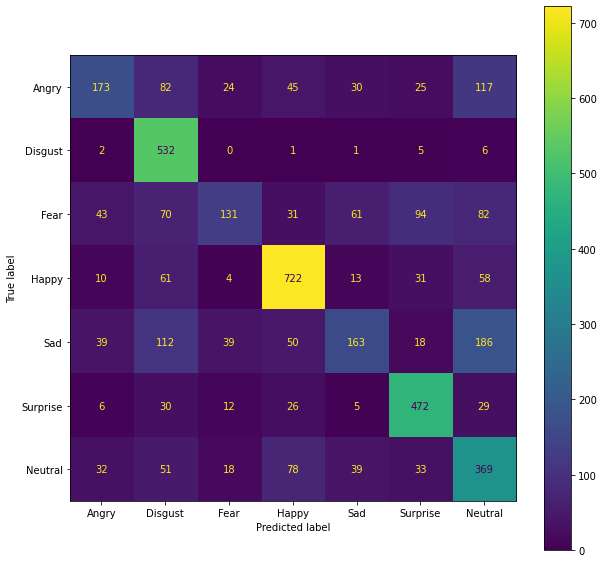

In [83]:
# computing the predictions on the test set
y_pred=model.predict(X_test,verbose=0) 

# creating the confusion matrix and the confusion matrix display
cm = confusion_matrix( y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(cm,display_labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"])

# creating the figure and axes
fig, ax = plt.subplots(figsize=(10,10))

# plotting the confusion matrix
cm_display = cm_display.plot(ax=ax)

# Computing classification report and class accuracy

In [84]:
# Visualizing the classification report
print("Classification report: \n")
emotions = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]
print(classification_report(y_test.argmax(1),y_pred.argmax(1),labels = [0,1,2,3,4,5,6],target_names = emotions))
print("\n")

# Computing and visualizing class accuracy

print("Class accuracy: \n")
cl_acc = []
tp_p_tn = cm.diagonal().sum()
for i in range(7):
  fp = cm[:,i].sum()
  fn = cm[i].sum()
  acc = tp_p_tn / (tp_p_tn+fp+fn-2*cm[i][i])
  cl_acc.append(acc)

for i in range(7):
  print("%s : %f\n"%(emotions[i],cl_acc[i]))
  



Classification report: 

              precision    recall  f1-score   support

       Angry       0.57      0.35      0.43       496
     Disgust       0.57      0.97      0.72       547
        Fear       0.57      0.26      0.35       512
       Happy       0.76      0.80      0.78       899
         Sad       0.52      0.27      0.35       607
    Surprise       0.70      0.81      0.75       580
     Neutral       0.44      0.60      0.50       620

    accuracy                           0.60      4261
   macro avg       0.59      0.58      0.56      4261
weighted avg       0.60      0.60      0.58      4261



Class accuracy: 

Angry : 0.849188

Disgust : 0.858867

Fear : 0.842763

Happy : 0.862626

Sad : 0.812044

Surprise : 0.890821

Neutral : 0.778487



# Saving the model
After training and testing the model we save it for future use.

In [85]:
model.save("/content/drive/MyDrive/Facial-Expression-Recognition/VGG16/VGG16.h5")

# Visualizing model performances
In this section the trained model will be loaded and then its performances will be displayed.\
More specifically:


*   A random batch of images will be extracted from the Test Set.
*   The extracted images will be displayed with their real labels (groundtruth)
* The extracted images will be displayed with the labels predicted by the model



In [86]:
# Loading the model
model = load_model("/content/drive/MyDrive/Facial-Expression-Recognition/VGG16/VGG16.h5")

Enter the number of random images to extract: 15
Groundtruth:



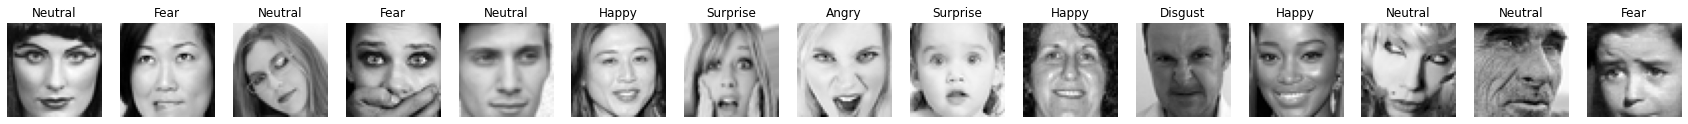



Model predictions:



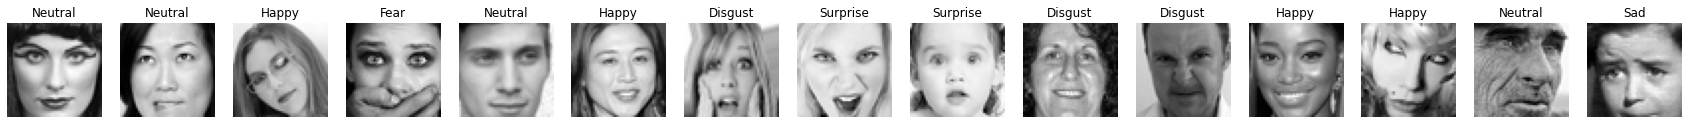

In [92]:
# Getting the number of random images to extract from the user
n = int(input("Enter the number of random images to extract: "))

# Generating the random images batch
images,labels = random_images(X_test,y_test,n)

# Visualizing the images with their real labels
print("Groundtruth:\n")
print_images_with_labels(images,labels)
print("\n")

# Visualizing the images with the predicted labels
pred = convert_to_tensor(model(images))
print("Model predictions:\n")
print_images_with_labels(images,pred)